# Quick examples

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/hybrid_flow_shop.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.
 
This notebook contains a number of quick examples to demonstrate PyJobShop features not contained in the other notebooks.

In [11]:
from pyjobshop import Model
from pyjobshop.plot import plot_machine_gantt

## Sequence-dependent setup times
Machines may require different configuration settings for processing different types of tasks. This results in _sequence-dependent setup times_, which is the time that is required to reconfigure machines between processing two tasks. Let's showcase a small example here.

In [12]:
model = Model()
tasks = [model.add_task() for _ in range(6)]
machines = [model.add_machine() for _ in range(2)]

for task in tasks:
    # The first machine is faster than the second machine.
    model.add_mode(task, machines[0], duration=1)
    model.add_mode(task, machines[1], duration=3)

for task1 in tasks:
    for task2 in tasks:
        model.add_setup_time(machines[0], task1, task2, duration=1)
        model.add_setup_time(machines[1], task1, task2, duration=2)

In [13]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 8.00
lower bound: 8.00
     status: Optimal
    runtime: 0.07 seconds


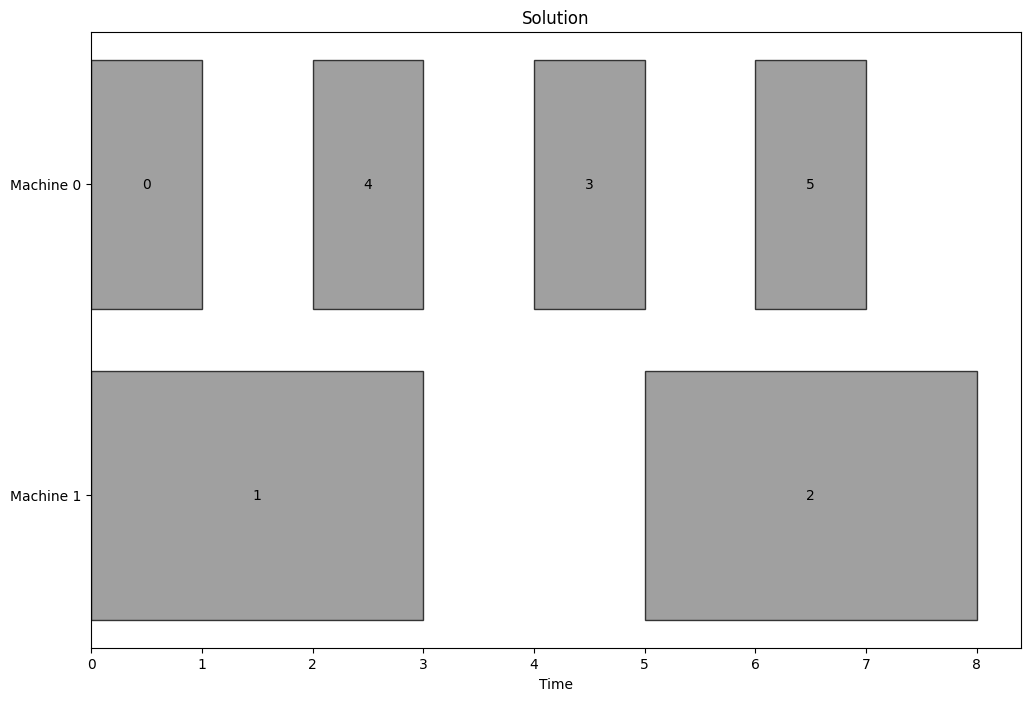

In [14]:
data = model.data()
plot_machine_gantt(result.best, data, plot_labels=True)

Some notes:

- Instances with sequence-dependent setup times are generally hard to solve, and it's even harder to solve to optimality. Consider using a time limit when solving such instances.
- Unlike CP Optimizer, OR-Tools does not have specialized constraints to deal with sequence-dependent setup times. This makes the implementation of OR-Tools substantially slower.

## Finding feasible solutions

In some situations, it may be only needed to find a feasible solution. You can achieve this by passing an additional parameter to the `solve` function, depending on the solver used:

- OR-Tools: `stop_after_first_solution=True`.
- CP Optimizer: `SolutionLimit=1`.

Below we demonstrate it with OR-Tools (used by default).

In [15]:
model = Model()
tasks = [model.add_task(name=idx) for idx in range(6)]
machines = [model.add_machine(name=idx) for idx in range(2)]

for task in tasks:
    model.add_mode(task, machines[0], duration=1)
    model.add_mode(task, machines[1], duration=3)

In [16]:
result = model.solve(display=False, stop_after_first_solution=True)
print(result)

Solution results
  objective: 18.00
lower bound: 1.00
     status: Feasible
    runtime: 0.01 seconds


Let's double-check that the optimal solution is better:

In [17]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 5.00
lower bound: 5.00
     status: Optimal
    runtime: 0.01 seconds


## No-idle machines

Sometimes machines must operate continuously without idle time between tasks. This constraint can be added to machines using the `no_idle=True` parameter. When enabled, tasks are scheduled back-to-back with no gaps (except for required setup times).

In [18]:
model = Model()
machine = model.add_machine(no_idle=True)

task1 = model.add_task(earliest_start=5, name="Task1")
task2 = model.add_task(name="Task2")

model.add_mode(task1, machine, duration=1)
model.add_mode(task2, machine, duration=2)

result = model.solve(display=False)

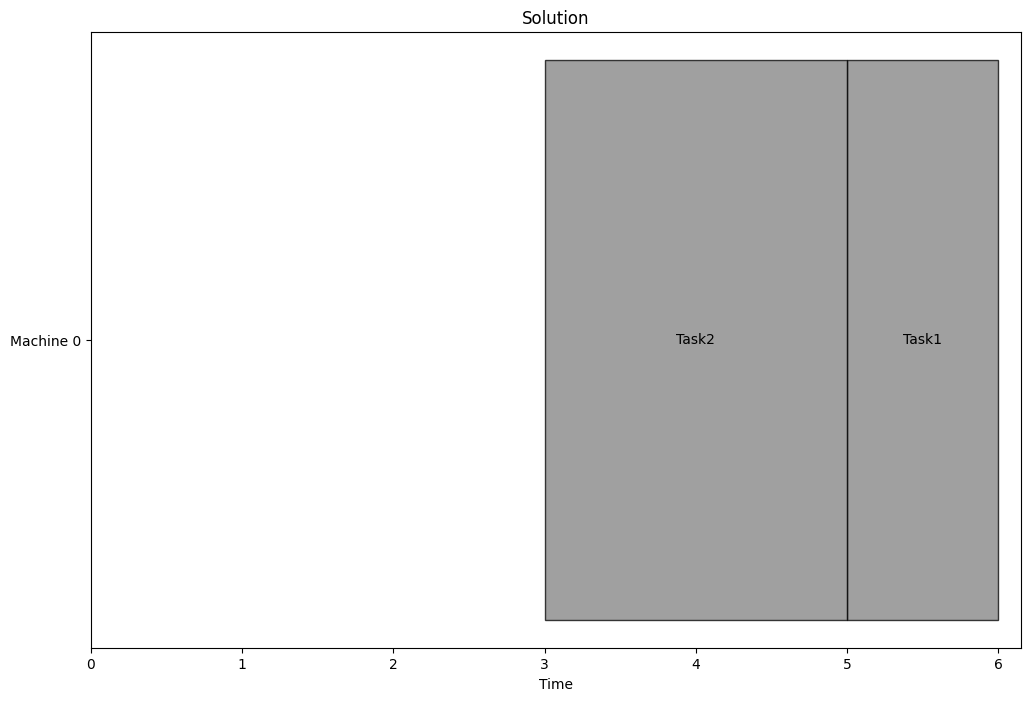

In [19]:
data = model.data()
plot_machine_gantt(result.best, data, plot_labels=True)

Since task 1 cannot start before time 5, the solver places task 2 at time 3-5 so the machine operates continuously without gaps and finishes as soon as possible.

Some notes:

- No-idle machines cannot have breaks defined (`breaks` parameter cannot be used with `no_idle=True`).
- This constraint is particularly useful for modeling continuous production processes where stopping and restarting the machine is costly.
- The no-idle constraint works with setup times - tasks are still scheduled back-to-back, but setup times are accounted for between tasks.

## Job shop with operator breaks

In many job shops, machines require operator supervision during setup but can operate independently during processing. This example shows how to model such scenarios using synchronized tasks with operator breaks.

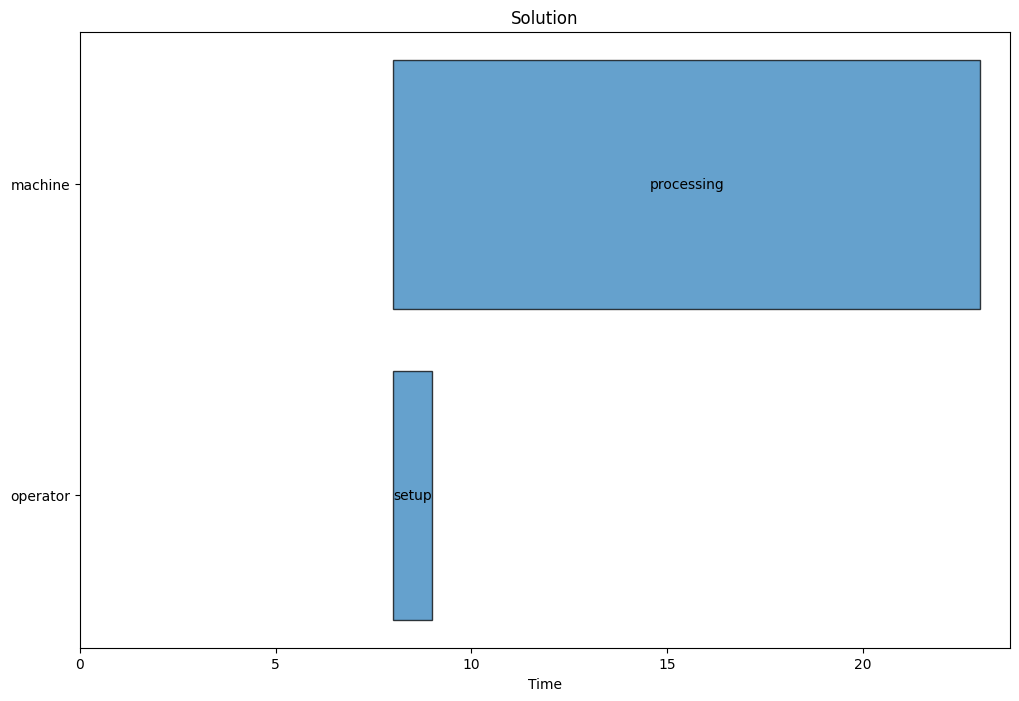

In [20]:
model = Model()
job = model.add_job()

# Create the machine resource and the operator resource (with breaks).
machine = model.add_machine(name="machine")
operator = model.add_machine(breaks=[(0, 8), (17, 24)], name="operator")

# The processing task is the one that will be processed by the machine.
processing_task = model.add_task(job, name="processing")
duration = 15
model.add_mode(processing_task, machine, duration=duration)

# The setup task is the one that will be processed by the operator.
setup_task = model.add_task(job, name="setup")
duration = 1
model.add_mode(setup_task, operator, duration=duration)

# The machine and operator task should start at the same time. This means
# that we can only start the setup when an operator is available, but
# the machine can continue processing without the operator. Note that
# using the start-before-start constraint twice with reverse arguments
# is the same as a start-at-start constraint.
model.add_start_before_start(processing_task, setup_task)
model.add_start_before_start(setup_task, processing_task)

# The plot shows that the tasks can only start when the operator is available,
# which is at time 8. The processing task starts at time 8 and ends at time 23,
# not requiring the operator's attendance during processing.
result = model.solve(display=False)
plot_machine_gantt(result.best, model.data(), plot_labels=True)

Key points in this example:

- The operator has breaks from 0-8 and 17-24, so they're only available during working hours (8-17).
- Both tasks must start simultaneously using bidirectional start-before-start constraints.
- The machine can continue processing after the operator finishes setup.
- The Gantt chart shows tasks starting at time 8 when the operator becomes available.